# Model Risk Pipeline

_Initial commit: Anton Markov, 19 November 2021_

Основная цель данного ноутбука — построить базовую структуру пайплайна с учетом оптимизации гиперпараметров.

Реализована оптимизация через `hyperopt`, в будущем возможно поддержка иных библиотек.

__Входные данные:__

1. Датасет
2. Модель
3. Список модулей, которые могут оптимизироваться в качества гиперпараметра

__Исходящие данные:__

1. Оптимальный набор модулей, согласно `hyperopt`
2. Параметры обученной оптимальной модели


## 1. Technicals

In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import umap

from sklearn import datasets, metrics, model_selection
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

from hyperopt import hp
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# import umap # does not work for me, since I installed umap instaed of umap-learn by mistake

# for HyperOpt class
import lightgbm as lgb
import xgboost as xgb
# import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

# новый пакет!
from feature_engine.encoding import WoEEncoder
from feature_engine.creation import CombineWithReferenceFeature
from feature_engine.encoding import OneHotEncoder

from typing import List, Union
from feature_engine.encoding.base_encoder import BaseCategoricalTransformer
from feature_engine.validation import _return_tags
from feature_engine.variable_manipulation import _check_input_parameter_variables

from mlxtend.feature_selection import SequentialFeatureSelector
from feature_engine.selection  import SelectByShuffling
from feature_engine.selection  import RecursiveFeatureAddition
from feature_engine.selection  import SmartCorrelatedSelection

In [2]:
seed = 42

In [3]:
def Gini(y, y_pred):
    res = roc_auc_score(y, y_pred) * 2 - 1
    print(f"Gini: {res}")
    return(res)

In [4]:
def filter_params(params, pipe):
    '''
    From all input parameters filter only
    those that are relevant for the current
    pipeline
    '''
    pipe_steps = list(pipe.named_steps.keys())
    params_keys = list(params.keys())
    
    return {
        key: params[key]
        for key in params_keys
        if key.split('__')[0] in pipe_steps
    }

In [5]:
def construct_pipe(steps_dict, modules):
    '''
    Construct a pipeline given structure
    '''
    return [(steps_dict[s], modules[steps_dict[s]]) for s in steps_dict if steps_dict[s] != 'skip']

In [6]:
class PipeHPOpt(object):
    '''
    Класс PipeHPOpt — Pipeline with hyperparameter optimisation
    using hyperopt — нацелен на оптимизацию пайплайна как с точки
    зрения входящих в него модулей, так и гиперпараметров каждого
    из модулей
    '''  
    def __init__(self, X, y, modules, mode='kfold', n_folds = 5, test_size=.33, seed=42):
        '''   
        _inputs:
        X — train dataset
        y — train targets
        modules — dict of all modules that might potentially be included into
            the pipeline
        mode — wither "kfold" or "valid" (error if other) — sets if X, y will
            be subdivided into k cross-validation samples or train/test samples,
            respectively. "kfold" is default. Key advantage of valid: it returns
            the optimal model; in "kfold" mode the model should be retrained with
            optimal hyperparameters
        n_folds — number of folds at cross-validation (5 is default). Applied
            only if mode = "kfold". Warning added
        test_size — test sample % (.33 is default). Applied only if mode = "valid". 
            Warning added
        seed — random seed (42 is default)
        '''
        if (mode != 'kfold') & (mode != 'valid'):
            raise ValueError("Choose mode 'kfold' or 'valid'")
        if (mode == 'valid') & (n_folds != 5):
            import warnings
            warnings.warn("Non-default n_folds won't be used since mode == valid!")
        if (mode == 'kfold') & (test_size != .33):
            import warnings
            warnings.warn("Non-default test_size won't be used since mode == kfold!")
            
        self.X       = X
        self.y       = y
        self.mode    = mode
        self.n_folds = n_folds
        self.seed    = seed
        self.modules = modules
        
        if mode == 'valid':
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                X, y, test_size=test_size, random_state=seed
            )

    def process(self, space, trials, algo, max_evals, fn_name='_pipe'):
        '''
        _inputs: TBD
        
        _output:
        result: hyperopt weird object of the optimal model representation
        trials: info on each of the hyperopt trials
        '''
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        self.result = result
        self.trials = trials
        return result, trials

    
    def get_best_params(self):
        return self.trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
    
    def get_best_model(self):
        para = self.get_best_params()
        pipe_steps = [(para['pipe_params'][i], modules[para['pipe_params'][i]]) for i in para['pipe_params'] if para['pipe_params'][i] != 'skip']
        reg = Pipeline(pipe_steps)
        for p in pipe_para['set_params']:
            try:
                reg.set_params({p: para[p]})
            except:
                pass # repetition, not DRY, think how to delete
        return reg.fit(self.X, self.y)
    
    def _pipe(self, para):
        # print(para)
        pipe_steps = [(para['pipe_params'][i], modules[para['pipe_params'][i]]) for i in para['pipe_params'] if para['pipe_params'][i] != 'skip']
        reg = Pipeline(pipe_steps)
        for p in pipe_para['set_params']:
            try:
                reg.set_params({p: para[p]})
            except:
                pass
        if self.mode == 'kfold':
            return self._train_reg_kfold(reg, para)
        elif self.mode == 'valid':
            return self._train_reg_valid(reg, para)

    def _train_reg_valid(self, reg, para):
        reg.fit(self.x_train, self.y_train)
        pred = reg.predict_proba(self.x_test)[:, 1]
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'model': reg, 'params': para, 'status': STATUS_OK}
    
    def _train_reg_kfold(self, reg, para):
        kf = KFold(n_splits=5, shuffle=True, random_state=self.seed)
        losses = []
        for train_index, test_index in kf.split(self.X):
            X_split_train, X_split_test = self.X.iloc[train_index, :], self.X.iloc[test_index, :]
            y_split_train, y_split_test = self.y.iloc[train_index, ],  self.y.iloc[test_index, ]
            reg.fit(X_split_train, y_split_train)
            pred = reg.predict_proba(X_split_test)[:, 1]
            loss = para['loss_func'](y_split_test, pred)
            losses.append(loss)
        return {'loss': np.mean(losses), 'params': para, 'status': STATUS_OK}

        

## 2. Import Dataset

In [7]:
X_train = pd.read_parquet('../datasets/01_german/samples/X_train.parquet')
y_train = pd.read_parquet('../datasets/01_german/samples/y_train.parquet').target

# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_test  = pd.read_parquet('../datasets/01_german/samples/X_test.parquet')
y_test  = pd.read_parquet('../datasets/01_german/samples/y_test.parquet').target

In [8]:
with open('../datasets/01_german/factors.json') as json_file:
    factors_dict = json.load(json_file)

In [9]:
factors_dict['cat_vals']

['cheq_acc',
 'cred_hist',
 'purp',
 'save_acc',
 'empl_t',
 'pers_status',
 'guarant_flg',
 'prop',
 'inst_plan',
 'house',
 'job',
 'tel_flg',
 'foreign_flg']

## 3. Define Modules

All the modules that might be part of the pipeline should be defined below (or import them):

In [10]:
class CombineWithReferenceFeature_adj():
    """
    Обертка вокруг CombineWithReferenceFeature()
    Позволяет не устанавливать параметры
    + variables_to_combine
    + reference_variables
    заранее (иначе не будет работать с OneHotEncoder
    и прочими преобразователями данных, а делать это при .fit()
    """
    def __init__(self, operations):
        self.operations = operations
        
    def fit(self, X, y):
        self.combinator = CombineWithReferenceFeature(
            variables_to_combine = list(X.columns),
            reference_variables = list(X.columns),
            operations = self.operations
        )
        self.combinator.fit(X, y)
        return(self)
    
    def transform(self, X):
        return(self.combinator.transform(X))        

In [11]:
class DimensionReducer():
    """
    Обертка нужна:
    1. Чтобы не заменять фичи, а добавлять их к исходному df
    2. Для PCA ouput = np.array, требуется заменить на pd.DataFrame 
    """
    def __init__(self, gen_class, **kwargs):
        self.reducer = gen_class(**kwargs)
        # self.reducer.set_params()
        
    def fit(self, X, y):
        self.reducer.fit(X, y)
        return self
    
    def transform(self, X):
        # potentially 
        return pd.concat([X, pd.DataFrame(self.reducer.transform(X), index = X.index)], axis=1)
    
    def set_params(self, **kwargs):
        self.reducer.set_params(**kwargs)
        return self     

In [12]:
# from typing import List, Union

# import numpy as np
# import pandas as pd

# from feature_engine.encoding.base_encoder import BaseCategoricalTransformer
# from feature_engine.validation import _return_tags
# from feature_engine.variable_manipulation import _check_input_parameter_variables

class WoEEncoder_adj(BaseCategoricalTransformer):
    def __init__(
        self,
        variables: Union[None, int, str, List[Union[str, int]]] = None,
        ignore_format: bool = False,
    ) -> None:

        if not isinstance(ignore_format, bool):
            raise ValueError("ignore_format takes only booleans True and False")

        self.variables = _check_input_parameter_variables(variables)
        self.ignore_format = ignore_format

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Learn the WoE.
        Parameters
        ----------
        X: pandas dataframe of shape = [n_samples, n_features]
            The training input samples.
            Can be the entire dataframe, not just the categorical variables.
        y: pandas series.
            Target, must be binary.
        """
        
        X = self._check_fit_input_and_variables(X)

        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        # check that y is binary
        if y.nunique() != 2:
            raise ValueError(
                "This encoder is designed for binary classification. The target "
                "used has more than 2 unique values."
            )

        temp = pd.concat([X, y], axis=1)
        temp.columns = list(X.columns) + ["target"]

        # if target does not have values 0 and 1, we need to remap, to be able to
        # compute the averages.
        if any(x for x in y.unique() if x not in [0, 1]):
            temp["target"] = np.where(temp["target"] == y.unique()[0], 0, 1)

        self.encoder_dict_ = {}

        total_pos = temp["target"].sum()
        total_neg = len(temp) - total_pos
        temp["non_target"] = np.where(temp["target"] == 1, 0, 1)

        for var in self.variables_:
            pos = (temp.groupby([var])["target"].sum() + .5) / total_pos
            neg = (temp.groupby([var])["non_target"].sum() + .5) / total_neg

            t = pd.concat([pos, neg], axis=1)
            t["woe"] = np.log(t["target"] / t["non_target"])

            # we make an adjustment to override this error
            # if (
            #     not t.loc[t["target"] == 0, :].empty
            #     or not t.loc[t["non_target"] == 0, :].empty
            # ):
            #     raise ValueError(
            #         "The proportion of one of the classes for a category in "
            #         "variable {} is zero, and log of zero is not defined".format(var)
            #     )

            self.encoder_dict_[var] = t["woe"].to_dict()

        self._check_encoding_dictionary()

        self.n_features_in_ = X.shape[1]

        return self

    # Ugly work around to import the docstring for Sphinx, otherwise not necessary
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = super().transform(X)

        return X

    transform.__doc__ = BaseCategoricalTransformer.transform.__doc__

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = super().inverse_transform(X)

        return X

    inverse_transform.__doc__ = BaseCategoricalTransformer.inverse_transform.__doc__

    def _more_tags(self):
        tags_dict = _return_tags()
        # in the current format, the tests are performed using continuous np.arrays
        # this means that when we encode some of the values, the denominator is 0
        # and this the transformer raises an error, and the test fails.
        # For this reason, most sklearn transformers will fail. And it has nothing to
        # do with the class not being compatible, it is just that the inputs passed
        # are not suitable
        tags_dict["_skip_test"] = True
        return tags_dict

In [13]:
WoE_module = WoEEncoder_adj(variables = factors_dict['cat_vals'])

OneHot_module = OneHotEncoder(variables = factors_dict['cat_vals'])

PCA_module = DimensionReducer(
    gen_class = sklearn.decomposition.PCA,
    n_components = 2,    # сколько оставить компонентов; по дефолту - все
    whiten = False,      # отключаем whitening - декорреляцию фичей
    svd_solver = "full", # детали SVD преобразования, за подробностями см. доки
)

kPCA_module = DimensionReducer(
    gen_class = sklearn.decomposition.KernelPCA,
    n_components = 8,  # сколько оставить компонентов; по дефолту - все
    kernel = "linear", # ядро. По дфеолту линейное. Можно сделать своё, но тогда его нужно предварительно вычислить отдельно,
                       # поставить kernel = "precomputed" и передать уже вычисленное ядро в качестве X
    degree = 3,        # степень полинома для некоторых типов ядер. Важный параметр для тьюнинга, но сильно напрягает процессор
    n_jobs = -1        # объект умеет быть многопоточным! -1 займет все ядра
)

Isomap_module = DimensionReducer(
    gen_class = sklearn.manifold.Isomap,
    n_neighbors = 5, #количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 2,  #сколько оставить компонент; по дефолту - 2
    path_method = "auto", #алгоритм, который вычисляет кратчайший путь. Варианты см. на странице функции. Этот подбирает сам.
    neighbors_algorithm = "auto", #алгоритм, который ищет соседей. Инстанс класса NearestNeighbours
    n_jobs = -1 #объект умеет быть многопоточным! -1 займет все ядра
)

UMAP_module = DimensionReducer(
    gen_class = umap.UMAP,
    n_neighbors = 5,  # количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 2, # сколько оставить компонентов; по дефолту - 2
    min_dist = 0.1    # минимальная дистанция, которую можно сохранять между точками в получающемся пространстве. 
    # Гиперпараметр. При увеличении начинает лучше улавливать общую структуру, но хуже - локальную
)

CombWRef_module = CombineWithReferenceFeature_adj(
    operations = ['mul']
)

lgbm_mdl = LGBMClassifier(
    num_leaves = 10,
    learning_rate = .1,
    reg_alpha = 8,
    reg_lambda = 8,
    random_state = seed
)

# Tackling imbalances in target
RUS_module    = RandomUnderSampler(random_state = seed)
ROS_module    = RandomOverSampler(random_state = seed)
SMOTE_module  = SMOTE(random_state = seed)
ADASYN_module = ADASYN(random_state = seed)

# feature selection
SeqFearSel_module = SequentialFeatureSelector(
    estimator  = lgbm_mdl,  
    # k_features = 5,                                                  
    forward    = True,                                                  
    floating   = True,                                                
    verbose    = 0,
    cv         = 5
)
RecFeatAdd_module = RecursiveFeatureAddition(
    lgbm_mdl,
    threshold = 0.005
)
# SelShuffl_module = SelectByShuffling(
#     estimator = lgbm_mdl,
#     # variables=X.columns.to_list(),                                      # можно задать подмножество
#     scoring='roc_auc',                                                  # метрика
#     threshold=0.01,                                                     # порог ее снижения
#     cv=5,
#     random_state=42
# )
SmartSel_module = SmartCorrelatedSelection(
    # variables=X.columns.to_list(),
    method="pearson",                # можно взять свою функцию
    threshold=0.3,                   # порог корреляции
    selection_method="variance",     # из коррелирующих групп выбираем признак с наиб дисперсией
    estimator=None,                  # понадобится для selection_method="model_performance"        
    cv=5
)


In [14]:
modules = {
    'WoE':         WoE_module,
    'OneHot':      OneHot_module,
    'PCA':         PCA_module,
    'kPCA':        kPCA_module,
    'Isomap':      Isomap_module,
    'UMAP':        UMAP_module,
    'CombWRef':    CombWRef_module,
    'RecFeatAdd':  RecFeatAdd_module,
    'lgbm':        lgbm_mdl,
    'RUS':         RUS_module,      
    'ROS':         ROS_module,      
    'SMOTE':       SMOTE_module,  
    'ADASYN':      ADASYN_module,
    'SeqFearSel':  SeqFearSel_module,
    'RecFeatAdd':  RecFeatAdd_module,
    # 'SelShuffl':   SelShuffl_module,
    'SmartSel':    SmartSel_module    
}

## 4. Define Pipeline

Статья с примером [здесь](https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e).

### 4.1. Структура Pipeline

Определим структуру самого пайплайна. Словесное описание:
    
1. Энкодинг категориальных переменных:
    + OneHotEncoder
    + WoE
3. Feature Engineering:
    + PCA
    + Kernel PCA
    + Isomap
    + UMAP
    + Combine with Reference (feature multiplication)
    + _отсутствует_
4. Feature Selection:
    + RecursiveFeatureAddition
    + SequentialFeatureSelector
    + SmartCorrelatedSelection
    + _отсутствует_
4. Resampling:
    + Randomised Undersampling (RUS)
    + Randomised Oversampling  (ROS)
    + Synthetic Minority Oversampling Technique (SMOTE)
    + Adaptive Synthetic (ADASYN)
    + _отсутствует_
5. LightGBM

А так это будет выражаться в коде:

In [15]:
pipe_params = {
    # 'missing_vals': 
    'cat_encoding':  hp.choice('cat_encoding', ['OneHot', 'WoE']), # , 'woe' пропустить нельзя из-за наличия кат. пер-х
    'imbalance':     hp.choice('imbalance',    ['skip', 'RUS', 'ROS', 'SMOTE', 'ADASYN']),
    'feat_eng':      hp.choice('feat_eng',     ['skip', 'PCA', 'kPCA', 'Isomap', 'UMAP']), # , 'CombWRef' # удалил, т.к. долго считается
    # 'feat_filter':   hp.choice() -- unstable, low quality (SHAP, IV, feat_importance, ...) 
    'feat_sel':      hp.choice('feat_sel',     ['skip', 'SeqFearSel', 'RecFeatAdd', 'SmartSel']), # 'SelShuffl' is omitted, since it might drop all Xs
    'lgbm':          'lgbm'
}

Заметим, что 'skip' позволяет игнорировать соответствующий шаг в пайплайне. Названия типа `"onehot"` должны совпадать с названиями в словаре `modules`, который мы определили на Шаге 3.

### 4.2. Гиперпараметры модулей

В следующий словарь добавляем гиперпараметры каждого из модулей, которые мы хотим оптимизировать. Названия строятся следующи образом:

`<Название модуля>__<название параметра>`

Например, чтобы задать параметр `num_leaves` модуля lgbm, трубуется добваить значение с ключем `lgbm__num_leaves`.

In [16]:
set_params = {
    # OneHotEncoder does not need hyperparams
    # RecFeatAdd might be redefined to receive a correct estimator
    # PCA
    'DimRed__PCA__n_components':      hp.choice('PCA__n_components',      np.arange(2, 11)),
    'DimRed__PCA__whiten':            hp.choice('PCA__whiten',            [True, False]),
    'DimRed__PCA__svd_solver':        hp.choice('PCA__svd_solver',        ['full', 'arpack', 'auto', 'randomized']),
    
    # kPCA
    'DimRed__kPCA__n_components':     hp.choice('kPCA__n_components',     np.arange(5, 11)),
    'DimRed__kPCA__kernel':           hp.choice('kPCA__kernel',           ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']),
    
    # Isomap
    'DimRed__Isomap__n_neighbors':    hp.choice('Isomap__n_neighbors',    np.arange(2, 11)),
    'DimRed__Isomap__n_components':   hp.choice('Isomap__n_components',   np.arange(2, 5)),
    'DimRed__Isomap__path_method':    hp.choice('Isomap__path_method',    ['auto', 'FW', 'D']),
    
    # UMAP
    'DimRed__UMAP__n_neighbors':      hp.choice('UMAP__n_neighbors',      np.arange(2, 11)),
    'DimRed__UMAP__n_components':     hp.choice('UMAP__n_components',     np.arange(2, 11)),
    'DimRed__UMAP__min_dist':         hp.choice('UMAP__min_dist',         np.arange(0.05, 1, 0.05)),
    
    # LightGBM
    'lgbm__learning_rate':    hp.choice('lgbm__learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'lgbm__num_leaves':       hp.choice('lgbm__num_leaves',       np.arange(5, 16, 1, dtype=int)),
    'lgbm__reg_alpha':        hp.choice('lgbm__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'lgbm__reg_lambda':       hp.choice('lgbm__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'lgbm__n_estimators':     100
}

Чтобы параметры можно было оптимизировать, модули должны иметь метод `.set_params()`.

### 4.3. Подстановка оптимизационной задачи

In [17]:
# technicals — define minimization task
pipe_para = dict()
pipe_para['pipe_params']    = pipe_params
pipe_para['set_params']     = set_params
pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.roc_auc_score(y, pred)
# pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.log_loss(y, pred)

In [18]:
%%capture --no-stdout
hpoptimizer = PipeHPOpt(X_train, y_train, modules=modules, mode='kfold', n_folds = 5, seed=seed)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=Trials(), algo=tpe.suggest, max_evals=1000)

# hpoptimizer = PipeStructHPOpt(X_train, y_train, modules, space_params=set_params, mode='kfold', n_folds = 5, seed=seed)
# lgb_opt, trials = hpoptimizer.process(space_steps=steps, trials=Trials(), algo=tpe.suggest, max_evals=10)

100%|██████████████████████████████████████████| 1000/1000 [1:38:46<00:00,  5.93s/trial, best loss: -0.781055342129054]


### 4.4. Анализ результатов

In [19]:
hpoptimizer.get_best_params()

{'loss_func': <function __main__.<lambda>(y, pred)>,
 'pipe_params': {'cat_encoding': 'WoE',
  'feat_eng': 'Isomap',
  'feat_sel': 'skip',
  'imbalance': 'ROS',
  'lgbm': 'lgbm'},
 'set_params': {'DimRed__Isomap__n_components': 3,
  'DimRed__Isomap__n_neighbors': 2,
  'DimRed__Isomap__path_method': 'D',
  'DimRed__PCA__n_components': 7,
  'DimRed__PCA__svd_solver': 'auto',
  'DimRed__PCA__whiten': True,
  'DimRed__UMAP__min_dist': 0.5,
  'DimRed__UMAP__n_components': 3,
  'DimRed__UMAP__n_neighbors': 8,
  'DimRed__kPCA__kernel': 'rbf',
  'DimRed__kPCA__n_components': 7,
  'lgbm__learning_rate': 0.15000000000000002,
  'lgbm__n_estimators': 100,
  'lgbm__num_leaves': 5,
  'lgbm__reg_alpha': 2,
  'lgbm__reg_lambda': 5}}

In [20]:
best_mdl = hpoptimizer.get_best_model()
best_mdl

d:\project\credit_scoring_project\venv\lib\site-packages\sklearn\manifold\_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
d:\project\credit_scoring_project\venv\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
d:\project\credit_scoring_project\venv\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
d:\project\credit_scoring_project\venv\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_int

Pipeline(steps=[('WoE',
                 WoEEncoder_adj(variables=['cheq_acc', 'cred_hist', 'purp',
                                           'save_acc', 'empl_t', 'pers_status',
                                           'guarant_flg', 'prop', 'inst_plan',
                                           'house', 'job', 'tel_flg',
                                           'foreign_flg'])),
                ('Isomap',
                 <__main__.DimensionReducer object at 0x0000029DDF8FC220>),
                ('ROS', RandomOverSampler(random_state=42)),
                ('lgbm',
                 LGBMClassifier(num_leaves=10, random_state=42, reg_alpha=8,
                                reg_lambda=8))])

In [21]:
Gini(y_train, best_mdl.predict_proba(X_train)[:, 1])
Gini(y_test, best_mdl.predict_proba(X_test)[:, 1])

Gini: 0.7997758296899471
Gini: 0.5766318067075369


0.5766318067075369

In [22]:
[r['loss'] for r in trials.results]

[-0.7763669646161422,
 -0.7228210631471275,
 -0.7279980280703995,
 -0.6765648599565901,
 -0.6822371267211811,
 -0.7113882733634889,
 -0.7469058170762046,
 -0.7611981268975534,
 -0.7606953878949908,
 -0.7619889593150948,
 -0.7763669646161422,
 -0.7190113457977975,
 -0.6863881490638676,
 -0.6066135856896097,
 -0.6822371267211811,
 -0.6173813969431191,
 -0.6075934839456696,
 -0.5628305070332584,
 -0.7432235356983659,
 -0.7279980280703995,
 -0.7697616993719443,
 -0.7763669646161422,
 -0.7763669646161422,
 -0.7763669646161422,
 -0.7659708443244196,
 -0.745541706328382,
 -0.7763669646161422,
 -0.7763669646161422,
 -0.7295152578895017,
 -0.7766649805243923,
 -0.7799523659322172,
 -0.7799523659322172,
 -0.7521694772278444,
 -0.7621907552843671,
 -0.7799523659322172,
 -0.7799523659322172,
 -0.743174202500653,
 -0.7521694772278444,
 -0.7799523659322172,
 -0.7659708443244196,
 -0.7083253851737281,
 -0.7799523659322172,
 -0.7523034558312235,
 -0.7659215277197258,
 -0.7484745109835765,
 -0.74696238

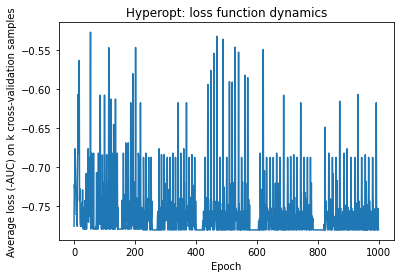

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(np.array([r['loss'] for r in trials.results]))
plt.title('Hyperopt: loss function dynamics')
plt.xlabel('Epoch')
plt.ylabel('Average loss (-AUC) on k cross-validation samples')
plt.show()
plt.savefig('loss_dynamics_hp_1000_tpe_suggest.png')